In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np


In [2]:
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('sample_data/clickbait_data.csv', sep=";")
df.head()

,"headline,clickbait",Unnamed: 1
0,"Should I Get Bings,1",NaN
1,"Which TV Female Friend Group Do You Belong In,1",NaN
2,"The New ""Star Wars: The Force Awakens"" Trailer...",NaN
3,"This Vine Of New York On ""Celebrity Big Brothe...",NaN
4,A Couple Did A Stunning Photo Shoot With Their...,NaN


In [4]:
new_data = []
for i in df["headline,clickbait"].values:
  if i[-1] == "1" or i[-1] == "0":
    new_data.append(i)

In [5]:
headline = [i[0: len(i)-2] for i in new_data]
label = [int(i[-1]) for i in new_data]
label = np.array(label)

In [6]:
Xlatih, Xtest, ylatih, ytest = train_test_split(headline, label, test_size=0.2)

In [7]:
stop_words = set(stopwords.words("english"))
judul_latih, judul_test = [],[]
data = [judul_latih, judul_test]
for i,j in enumerate([Xlatih, Xtest]):
  for x in range(len(j)):
    kata = ""
    word_token = word_tokenize(j[x])
    for w in word_token:
      if w.casefold() not in stop_words:
        kata += w.casefold()+" "
    data[i].append(kata.strip())

In [8]:
tk = Tokenizer(num_words=20736, oov_token='<OOV>')
tk.fit_on_texts(judul_latih)


sekuens_latih = tk.texts_to_sequences(judul_latih)
sekuens_test = tk.texts_to_sequences(judul_test)

pad_latih = pad_sequences(sekuens_latih,maxlen=20,padding='post',truncating='post')
pad_test = pad_sequences(sekuens_test,maxlen=20,padding='post',truncating='post')




In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20736, 16, input_length=20),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4))

In [10]:
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print('\nAkurasi telah mencapai > 80%')
      self.model.stop_training = True
callbacks = Mycallback()

In [11]:
hist = model.fit(pad_latih, ylatih, 
                    epochs=100, 
                    validation_data=(pad_test, ytest), 
                    verbose=2, 
                    callbacks=[callbacks], 
                    steps_per_epoch=25)

Epoch 1/100
25/25 - 5s - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4991 - 5s/epoch - 205ms/step
Epoch 2/100
25/25 - 3s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.4991 - 3s/epoch - 122ms/step
Epoch 3/100
25/25 - 3s - loss: 0.6925 - accuracy: 0.5205 - val_loss: 0.6903 - val_accuracy: 0.7632 - 3s/epoch - 121ms/step
Epoch 4/100
25/25 - 2s - loss: 0.6588 - accuracy: 0.8804 - val_loss: 0.5440 - val_accuracy: 0.9299 - 2s/epoch - 97ms/step
Epoch 5/100

Akurasi telah mencapai > 80%
25/25 - 2s - loss: 0.2688 - accuracy: 0.9559 - val_loss: 0.1753 - val_accuracy: 0.9459 - 2s/epoch - 99ms/step


In [13]:
model.evaluate(pad_test, ytest)

199/199 [==============================] - 1s 5ms/step - loss: 0.1753 - accuracy: 0.9459


[0.17534275352954865, 0.94593745470047]

<function matplotlib.pyplot.show(close=None, block=None)>

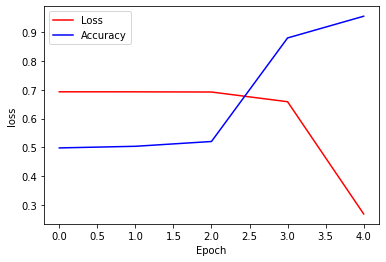

In [14]:
plt.plot(hist.history['loss'], color='red')
plt.plot(hist.history['accuracy'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(["Loss", 'Accuracy'])
plt.show